# Life history traits model  16 & 17  

Taylor Chapter 3  
model to describe age-structured life history traits of understudied Carcharhinid species

Model versions: 16 = mixed effects, uses depth ave, litter & offspring (not relative); habitat removed from previous run. comparable to model 12.   17= fixed effects model, all same covariates as 16. comparable to 15.  

### Set up notebook

In [1]:
#import packages
import datetime 
from itertools import product
import logging
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import os
from math import isnan
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import seaborn as sns
import pymc3 as pm  
from theano import tensor as tt
from theano import shared
import arviz as az
import warnings

%matplotlib inline  
#%matplotlib inline is a magic function that renders the figure in a notebook (instead of displaying a dump of the figure object)
from matplotlib import pyplot as plt 
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import FuncFormatter, StrMethodFormatter


In [2]:
# Aaron Helper function
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

match = lambda a, b: [ b.index(x) if x in b else None for x in a ]
grep = lambda s, l: np.array([i for i in l if s in i])

# Function to standardize covariates
def stdise(x):
    return (x-np.mean(x))/(np.std(x)*2)

def invlogit(x):
    return np.exp(x)/(1+np.exp(x))

def gelplot(pj,vector,posy,csize=40,lwd50=7,lwd95=1):
    if np.percentile(vector,2.5)<0 and 0<np.percentile(vector,97.5):
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='grey')
        pj.plot((np.percentile(vector,2.5),np.percentile(vector,97.5)),(posy,posy),linewidth=lwd95,c='grey')
        pj.plot((np.percentile(vector,25),np.percentile(vector,75)),(posy,posy),linewidth=lwd50,c='grey')
    else:
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='black')
        pj.plot((np.percentile(vector,2.5),np.percentile(vector,97.5)),(posy,posy),linewidth=lwd95,c='black')
        pj.plot((np.percentile(vector,25),np.percentile(vector,75)),(posy,posy),linewidth=lwd50,c='black')
        
    if np.percentile(vector,25)<0 and 0<np.percentile(vector,75):
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='white')

In [3]:
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Predict_Maturity\\Data\\for model\\in')
os.listdir() # list files in directory

['age_structured_traits.xlsx',
 'car_trait_covariates_v2.xlsx',
 'full_dataset.xlsx',
 'species_level_traits_v1.xlsx',
 'tmp_car_traits.csv',
 'tmp_car_traits.xlsx',
 '~$car_trait_covariates_v2.xlsx',
 '~$full_dataset.xlsx']

### Import and structure data

In [4]:
# Import full dataset
data = pd.read_excel('full_dataset.xlsx')
#get rid of species that don't have full complement of trait data
data = data[data.param_complete==0]
data.head()

,Species,Stock,Stock_Year,Age,maturity,survivorship,fecundity (num female pups per year),notes,model type,source_mat,...,linf_cm,growth_coeff_k,lmax_cm,age_max_yrs,temp_pref,nursery,depth_min,depth_max,depth_ave,param_complete
0,Carcharhinus acronotus,BNOS-GOM,BNOS-GOM-11,0,0.0000,0.59,0.0,survivorship= 1-M; fecundity = mat*average of ...,age-structured production,NMFS 2011,...,144.552147,0.288322,130.0,20.0,21.5,0.0,9.0,64.0,36.5,0.0
1,Carcharhinus acronotus,BNOS-GOM,BNOS-GOM-11,1,0.0000,0.7061,0.0,survivorship= 1-M; fecundity = mat*average of ...,age-structured production,NMFS 2011,...,144.552147,0.288322,130.0,20.0,21.5,0.0,9.0,64.0,36.5,0.0
2,Carcharhinus acronotus,BNOS-GOM,BNOS-GOM-11,2,0.0005,0.7445,2.5,survivorship= 1-M; fecundity = average of 5 pu...,age-structured production,NMFS 2011,...,144.552147,0.288322,130.0,20.0,21.5,0.0,9.0,64.0,36.5,0.0
3,Carcharhinus acronotus,BNOS-GOM,BNOS-GOM-11,3,0.0099,0.7663,2.5,survivorship= 1-M; fecundity = mat*average of ...,age-structured production,NMFS 2011,...,144.552147,0.288322,130.0,20.0,21.5,0.0,9.0,64.0,36.5,0.0
4,Carcharhinus acronotus,BNOS-GOM,BNOS-GOM-11,4,0.1751,0.7799,2.5,survivorship= 1-M; fecundity = mat*average of ...,age-structured production,NMFS 2011,...,144.552147,0.288322,130.0,20.0,21.5,0.0,9.0,64.0,36.5,0.0


In [5]:
#list columns
data.columns

Index(['Species', 'Stock', 'Stock_Year', 'Age', 'maturity', 'survivorship',
       'fecundity (num female pups per year)', 'notes', 'model type',
       'source_mat', 'source_sur', 'source_fec', 'source_m_link',
       'source_s_link', 'source_f_link', 'Cortes_2018', 'SA_mat', 'SA_sur',
       'SA_fec', 'FP_species', 'habitat', 'trophic_level', 'offspring_size_mm',
       'litter_size', 'interbirth_interval_yrs', 'age_50_maturity',
       'length_maturity_cm', 'linf_cm', 'growth_coeff_k', 'lmax_cm',
       'age_max_yrs', 'temp_pref', 'nursery', 'depth_min', 'depth_max',
       'depth_ave', 'param_complete'],
      dtype='object')

In [6]:
# make datafame of only stocks which have age-structured maturity data
# only data rows where SA-mat A
mdata= data[data.SA_mat=='A']
mdata.shape

(526, 37)

In [7]:
# make sure data is sorted properly
mdata = mdata.sort_values(by=['Stock_Year', 'Age'])


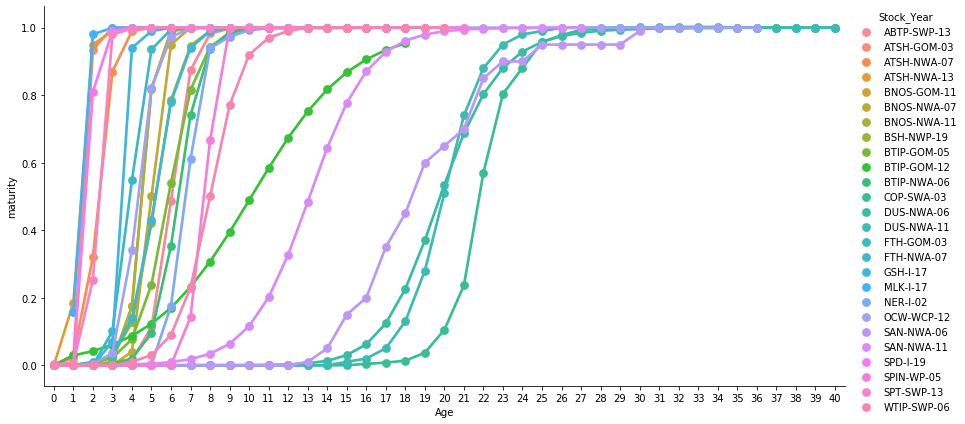

In [8]:
# visualise age-structured data
sns.catplot(x = "Age", y = "maturity", hue = "Stock_Year", height=6, aspect=2,
                kind="point", data = mdata);

## Format data

In [9]:
# Make arrays of response variables
AGE = mdata.Age.values
nobs = len(AGE)
MAT = mdata.maturity.values

In [10]:
# Make an index for stock-years 
# Puts an index value unique to the stock year for each row in df
StockYr, Is = indexall(mdata.Stock_Year.values)
nstocks = len(StockYr)
StockYr

['ABTP-SWP-13',
 'ATSH-GOM-03',
 'ATSH-NWA-07',
 'ATSH-NWA-13',
 'BNOS-GOM-11',
 'BNOS-NWA-07',
 'BNOS-NWA-11',
 'BSH-NWP-19',
 'BTIP-GOM-05',
 'BTIP-GOM-12',
 'BTIP-NWA-06',
 'COP-SWA-03',
 'DUS-NWA-06',
 'DUS-NWA-11',
 'FTH-GOM-03',
 'FTH-NWA-07',
 'GSH-I-17',
 'MLK-I-17',
 'NER-I-02',
 'OCW-WCP-12',
 'SAN-NWA-06',
 'SAN-NWA-11',
 'SPD-I-19',
 'SPIN-WP-05',
 'SPT-SWP-13',
 'WTIP-SWP-06']

In [11]:
#Index of covariates
Sind = np.array([list(mdata.Stock_Year.values).index(S) for S in StockYr])

#make arrays of all the covariates
#put Sind after all of these so they match the length of StockYr
LMAX = mdata.lmax_cm.values[Sind]
HAB = mdata.habitat.values[Sind]
TROPH = mdata.trophic_level.values[Sind]
OFFSZ = mdata.offspring_size_mm.values[Sind]
#ROFFSZ = mdata.relative_offspring_size.values[Sind]
LITT = mdata.litter_size.values[Sind]
#RLITT = mdata.relative_litter_size.values[Sind]
INTR = mdata.interbirth_interval_yrs.values[Sind]
AMAT = mdata.age_50_maturity.values[Sind]
LMAT = mdata.length_maturity_cm.values[Sind]
LINF = mdata.linf_cm.values[Sind]
K = mdata.growth_coeff_k.values[Sind]
AMAX = mdata.age_max_yrs.values[Sind]
DEP = mdata.depth_ave.values[Sind]
DEPMAX = mdata.depth_max.values[Sind]
TEMP = mdata.temp_pref.values[Sind]

In [12]:
# standardise continuous covariates
LMAX = stdise(LMAX)
TROPH = stdise(TROPH)
OFFSZ = stdise(OFFSZ)
LITT = stdise(LITT)
INTR = stdise(INTR)
LMAT = stdise(LMAT)
LINF = stdise(LINF)
K = stdise(K)
AMAX = stdise(AMAX)
DEP = stdise(DEP)
DEPMAX = stdise(DEPMAX)
TEMP = stdise(TEMP)


# Bayes model

Maturity model has 2 parts to assess the 2 parameters which describe the maturity curve

$$m = \frac{1}{1+e^{-S}(a-a_{50})}$$


a50 null model:
$$
\small{
a_{50} \sim Normal(Ga_{50},\sigma a_{50}) \\ 
Ga_{50} \sim Uniform(1.5, 25)  \\
\sigma a_{50} \sim Exponential(0.5) 
}
$$



S null model:
$$
\small{
S \sim Normal(GS,\sigma S) \\
GS \sim Uniform(0.01, 10)  \\
\sigma S \sim Exponential(1) 
}
$$

### Visualise Priors

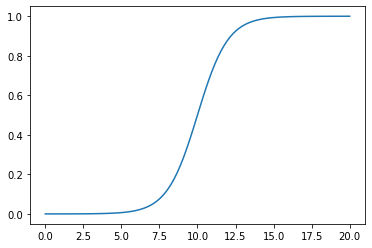

In [18]:
#make a figure of sigmoid with example maturity equation
def sigmoid(a):
    return(1/(1+np.exp(-1*(a-10))))
a = np.linspace(0,20,100)
plt.plot(a, sigmoid(a))

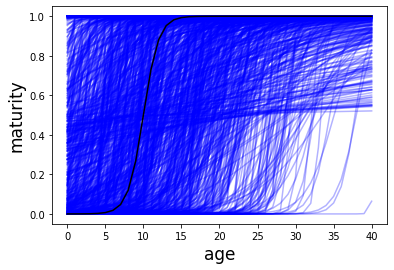

In [33]:
# try to visualise maturity slopes with prior a50 and S values
nsamp = 1000
a50 = np.random.normal(10, 10, nsamp)
S = np.random.exponential(1, nsamp)

ages = mdata.Age.unique()

#plot all possible ogives
[plt.plot(ages, 1/(1+np.exp(-S*(ages-a50))), c='blue', alpha=0.3) for a50,S in zip(a50, S)]
plt.xlabel('age', fontsize=10)
plt.ylabel('maturity', fontsize=10);

# a real ogive to see
plt.plot(ages, sigmoid(ages), c='black')

# Make it look nice
plt.xlabel('age', fontsize=17)
plt.ylabel('maturity', fontsize=17);

#save figure
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Predict_Maturity\\Data\\for model\\out')
#plt.savefig('prior_predictions.jpg');

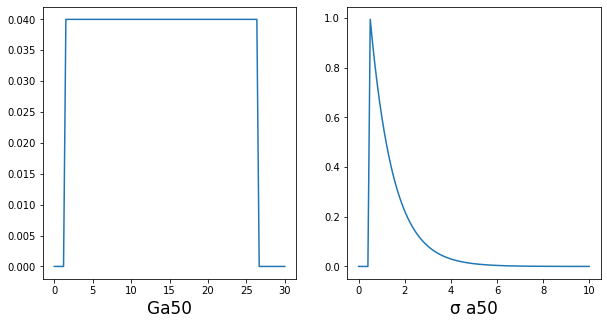

In [34]:
#visualise a50 priors here

# Setup multipanel figure
nrows, ncols = 1, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,5))
ax_ = axes.flatten()

# Plot range of Ga50 prior
# create 100 values between 0 and 30
x = np.linspace(0, 30, 100) 
ax_[0].plot(x, sp.stats.uniform.pdf(x, 1.5, 25))
# specify labels for chart 1
ax_[0].set_xlabel('Ga50', fontsize=17)

# Plot range of sigma prior
#create 100 values between -10 and 60
x = np.linspace(0, 10, 100)
#what is the likelihood of each potential sigma value given your uniform prior where the mean=0 and std dev=50
ax_[1].plot(x, sp.stats.expon.pdf(x, 0.5))
ax_[1].set_xlabel('σ a50', fontsize=17);

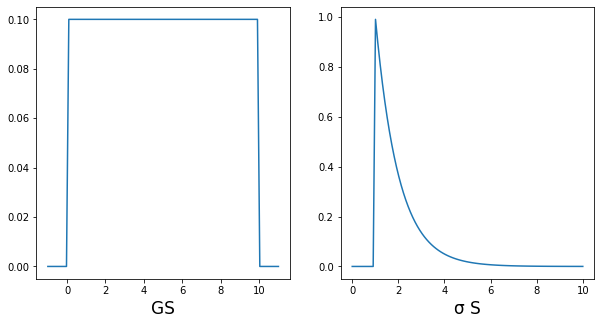

In [20]:
#visualise S priors here

# Setup multipanel figure
nrows, ncols = 1, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,5))
ax_ = axes.flatten()

# Plot range of GS prior
x = np.linspace(-1, 11, 100) #make the x axis
ax_[0].plot(x, sp.stats.uniform.pdf(x, 0.01, 10))
# specify labels for chart 1
ax_[0].set_xlabel('GS', fontsize=17)

# Plot range of sigma prior
#create 100 values between -10 and 60
x = np.linspace(0, 10, 100)
#what is the likelihood of each potential sigma value given your uniform prior where the mean=0 and std dev=50
ax_[1].plot(x, sp.stats.expon.pdf(x, 1))
ax_[1].set_xlabel('σ S', fontsize=17);

### Model Specification

In [15]:
# Model 16
# random effects model with stripped out covariates
with pm.Model() as mat1:
    
    # Hierarchical a50
    Ga50 = pm.Uniform('Ga50', 0, 30) #mean a50 has uniform distribution from 1.5 to 25
    a50_sigma = pm.Exponential('a50_sigma', 0.5) #std dev of a50 is exponential distribution with lambda of 0.5
    a50 = pm.Normal('a50_', Ga50, a50_sigma, shape=nstocks) #likelihood of a50 values given distributions of Ga50 and sigma_a50 (I think... what is shape for?)
    # set up priors for slope values between a50 and covariates
    # first argument is just a name not an actual dataset - doesn't need to match name of data array
    β1 = pm.Normal('Lmax', 0, 3) 
   # β2 = pm.Normal('Linf', 0, 3) # don't use Linf bc same thing as Lmax, also effect too similar to K
    β3 = pm.Normal('Depth', 0, 3)
  #  β4 = pm.Normal('K', 0, 3)
  #  β5_ = pm.Normal ('Habitat', 0, tau=0.01, shape=nhabitats-1) # 
  #  β5 = tt.set_subtensor(tt.zeros(shape=nhabitats)[1:], β5_)
    β6 = pm.Normal('Interbirth_interval', 0, 3)
    β7 = pm.Normal('Amax', 0, 3)
    β8 = pm.Normal('Litter', 0, 3)
    β9 = pm.Normal('Offspring_size', 0, 3)
    β10 = pm.Normal('Trophic', 0, 3)
  #  β11 = pm.Normal('Lmat', 0, 3)  # Don't use Lmat because same thing as a50
    β12 = pm.Normal('Temperature', 0, 3)
    
    
    # Hierarchical S
    # S is the curve parameter determining steepness/shape of maturity curve
    # GS is mean of distribution describing what S is
    # S_sigma is standard dev of distribution around GS
    GS = pm.Uniform('GS', 0.01, 10) # Uniform distribution of possible S values from 0.01 to 10
    S_sigma = pm.Exponential('S_sigma', 1) #Exponential distribution of possible sigma values with lambda of 1
    S = pm.Normal('S_', GS, S_sigma, shape=nstocks)
    
    # priors for covariates of S
   # B1 = pm.Normal('Lmax-S', 0, 3)
    B3 = pm.Normal('Depth-S', 0, 3)
    B4 = pm.Normal('K-S', 0, 3)
  #  B5_ = pm.Normal ('Habitat-S', 0, tau=0.01, shape=nhabitats-1) # 
  #  B5 = tt.set_subtensor(tt.zeros(shape=nhabitats)[1:], β5_)
  #  B6 = pm.Normal('Interbirth_interval-S', 0, 3)
    B7 = pm.Normal('Amax-S', 0, 3)
  #  B8 = pm.Normal('Litter-S', 0, 3)
  #  B9 = pm.Normal('Offspring_size-S', 0, 3)
    B10 = pm.Normal('Trophic-S', 0, 3)
    # no lmat because treating S and a50 as if they behave separately
    B12 = pm.Normal('Temperature-S', 0, 3)
    
    
    # a50 model
    # put all parameters that influence a50 here (all the β params from above)
    mu_a50 = pm.Deterministic("mu_a50", Ga50 + β1*LMAX + β3*DEP + β6*INTR + β7*AMAX + β8*LITT + β9*OFFSZ + β10*TROPH + β12*TEMP)
   # a50 = pm.Normal('a50_', mu_a50, a50_sigma, shape=nstocks) #stock level

    # Growth (S) model
    mu_S = pm.Deterministic("mu_S", GS + B3*DEP + B4*K + B7*AMAX + B10*TROPH + B12*TEMP)
   # S = pm.Normal('S_', mu_S, S_sigma, shape=nstocks) 
    
    # Growth model
    mu = 1/(1+tt.exp(-mu_S[Is]*(AGE-mu_a50[Is])))
    #mu = 1/(1+tt.exp(-S[Is]*(AGE-mu_a50[Is])))
    #mu = 1/(1+tt.exp(-S[Is]*(AGE-a50[Is])))

    # tt=under the hood modelling stuff - tensor flow package. makes exp work
    # Is is index values of stock codes

    # Likelihood
    S2 = pm.Uniform('S2', 0.0, 0.1) #variance for likelihood equation
    Yi = pm.Normal('Yi', mu, S2, observed=MAT)
    

In [16]:
# Sampling
# go back to 5000 for final run
with mat1:
    trace1 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [S2, Temperature-S, Trophic-S, Amax-S, K-S, Depth-S, S_, S_sigma, GS, Temperature, Trophic, Offspring_size, Litter, Amax, Interbirth_interval, Depth, Lmax, a50_, a50_sigma, Ga50]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6898 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 422 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.00031458610651540034, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [38]:
warnings.filterwarnings("ignore")
# warnings.filterwarnings("ignore", category=UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\arviz\plots\traceplot.py:195: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (22), generating only 20 plots
  UserWarning,


ValueError: cannot convert float NaN to integer

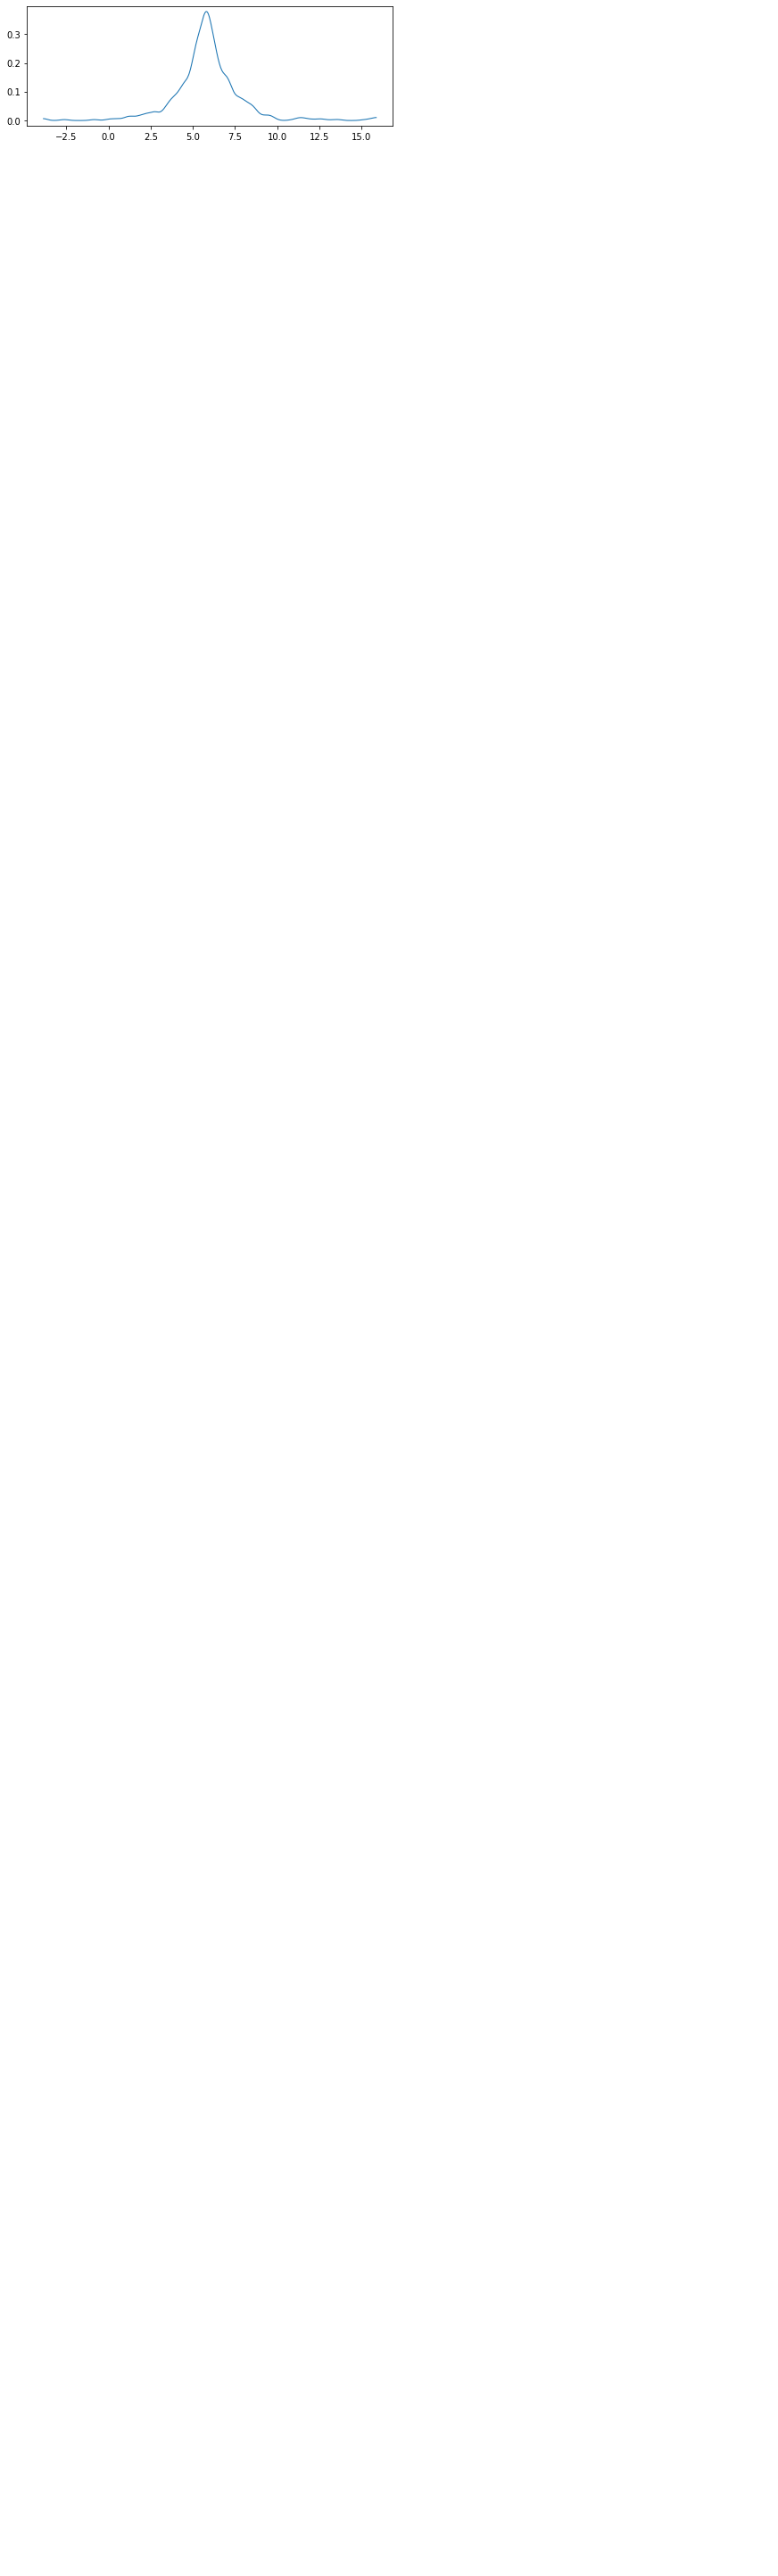

In [17]:
#check model performance
pm.traceplot(trace1);

In [18]:
pm.summary(trace1)
# looking for r-hat valeus of 1 - shows that model is converging

C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a50_[0],8.662,3.156,3.831,11.487,2.030,1.720,2.0,2.0,3.0,154.0,2.23
a50_[1],1.801,4.060,-1.836,7.240,2.613,2.133,2.0,2.0,3.0,2.0,2.23
a50_[2],9.864,4.414,3.702,14.015,2.955,2.547,2.0,2.0,3.0,43.0,2.24
a50_[3],4.103,2.150,2.466,7.958,1.194,0.935,3.0,3.0,4.0,2.0,2.24
a50_[4],4.666,2.018,2.974,8.833,0.671,0.509,9.0,8.0,5.0,71.0,2.25
...,...,...,...,...,...,...,...,...,...,...,...
mu_S[22],1.730,1.665,0.054,3.394,1.172,0.992,2.0,2.0,3.0,79.0,2.23
mu_S[23],0.967,0.122,0.661,1.094,0.053,0.040,5.0,5.0,7.0,68.0,2.23
mu_S[24],1.419,0.394,0.928,1.808,0.275,0.233,2.0,2.0,3.0,93.0,2.26
mu_S[25],1.698,0.607,1.110,2.525,0.417,0.349,2.0,2.0,3.0,2.0,2.26


In [36]:
# fixed effects model with stripped out S
# model 17
with pm.Model() as mat2:
    
    # Hierarchical a50
    Ga50 = pm.Uniform('Ga50', 0, 30) #mean a50 has uniform distribution from 1.5 to 25
    #a50_sigma = pm.Exponential('a50_sigma', 0.5) #std dev of a50 is exponential distribution with lambda of 0.5
    #a50 = pm.Normal('a50x', Ga50, a50_sigma) #likelihood of a50 values given distributions of Ga50 and sigma_a50 (I think... what is shape for?)
    # set up priors for slope values between a50 and covariates
    # first argument is just a name not an actual dataset - doesn't need to match name of data array
    β1 = pm.Normal('Lmax', 0, 3) 
   # β2 = pm.Normal('Linf', 0, 3)
    β3 = pm.Normal('Depth', 0, 3)
   # β4 = pm.Normal('K', 0, 3)
   # β5_ = pm.Normal ('Habitat', 0, tau=0.01, shape=nhabitats-1) # 
    # β5 = tt.set_subtensor(tt.zeros(shape=nhabitats)[1:], β5_)
    β6 = pm.Normal('Interbirth_interval', 0, 3)
    β7 = pm.Normal('Amax', 0, 3)
    β8 = pm.Normal('Litter', 0, 3)
    β9 = pm.Normal('Offspring_size', 0, 3)
    β10 = pm.Normal('Trophic', 0, 3)
 #   β11 = pm.Normal('Lmat', 0, 3)
    β12 = pm.Normal('Temperature', 0, 3)
    
    # Hierarchical S
    # S is the curve parameter determining steepness/shape of maturity curve
    # GS is mean of distribution describing what S is
    # S_sigma is standard dev of distribution around GS
     
    GS = pm.Uniform('GS', 0.01, 10) # Uniform distribution of possible S values from 0.01 to 10
   # S_sigma = pm.Exponential('S_sigma', 1) #Exponential distribution of possible sigma values with lambda of 1
   # S = pm.Normal('Sx', GS, S_sigma, shape=nstocks) 
    
    # now put all the priors for covariates of S
   # B1 = pm.Normal('Lmax-S', 0, 3)
    B3 = pm.Normal('Depth-S', 0, 3)
    B4 = pm.Normal('K-S', 0, 3)
   # β5 = pm.Normal ('Habitat', 0, 3) # How to set this up for a categorical variable?
   # B6 = pm.Normal('Interbirth_interval-S', 0, 3)
    B7 = pm.Normal('Amax-S', 0, 3)
  #  B8 = pm.Normal('Litter-S', 0, 3)
  #  B9 = pm.Normal('Offspring_size-S', 0, 3)
    B10 = pm.Normal('Trophic-S', 0, 3)
 #   B11 = pm.Normal('Lmat-S', 0, 3)
    B12 = pm.Normal('Temperature-S', 0, 3)
    
    # a50 model
    # put all parameters that influence a50 here (all the β params from above)
    mu_a50 = pm.Deterministic("mu_a50", Ga50 + β1*LMAX + β3*DEP + β6*INTR + β7*AMAX + β8*LITT + β9*OFFSZ + β10*TROPH + β12*TEMP)
 
    # Growth (S) model
    #put all parameters that influence S here 
    mu_S = pm.Deterministic("mu_S", GS + B3*DEP + B4*K + B7*AMAX + B10*TROPH + B12*TEMP)
    
    # Growth model
    # should there be an index for mu_S here? shouldn't there be just one s value?
    #mu = 1/(1+tt.exp(-S[Is]*(AGE-a50[Is])))
    mu = 1/(1+tt.exp(-mu_S[Is]*(AGE-mu_a50[Is])))

    # tt=under the hood modelling stuff - tensor flow package. makes exp work
    # Is is index values of stock codes

    # Likelihood
    S2 = pm.Uniform('S2', 0.0, 0.1) 
    Yi = pm.Normal('Yi', mu, S2, observed=MAT)
    

In [41]:
# Sampling
# go back to 5000 for final run
with mat2:
    trace2 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [S2, Temperature-S, Trophic-S, Amax-S, K-S, Depth-S, GS, Temperature, Trophic, Offspring_size, Litter, Amax, Interbirth_interval, Depth, Lmax, Ga50]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 953 seconds.
There were 170 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


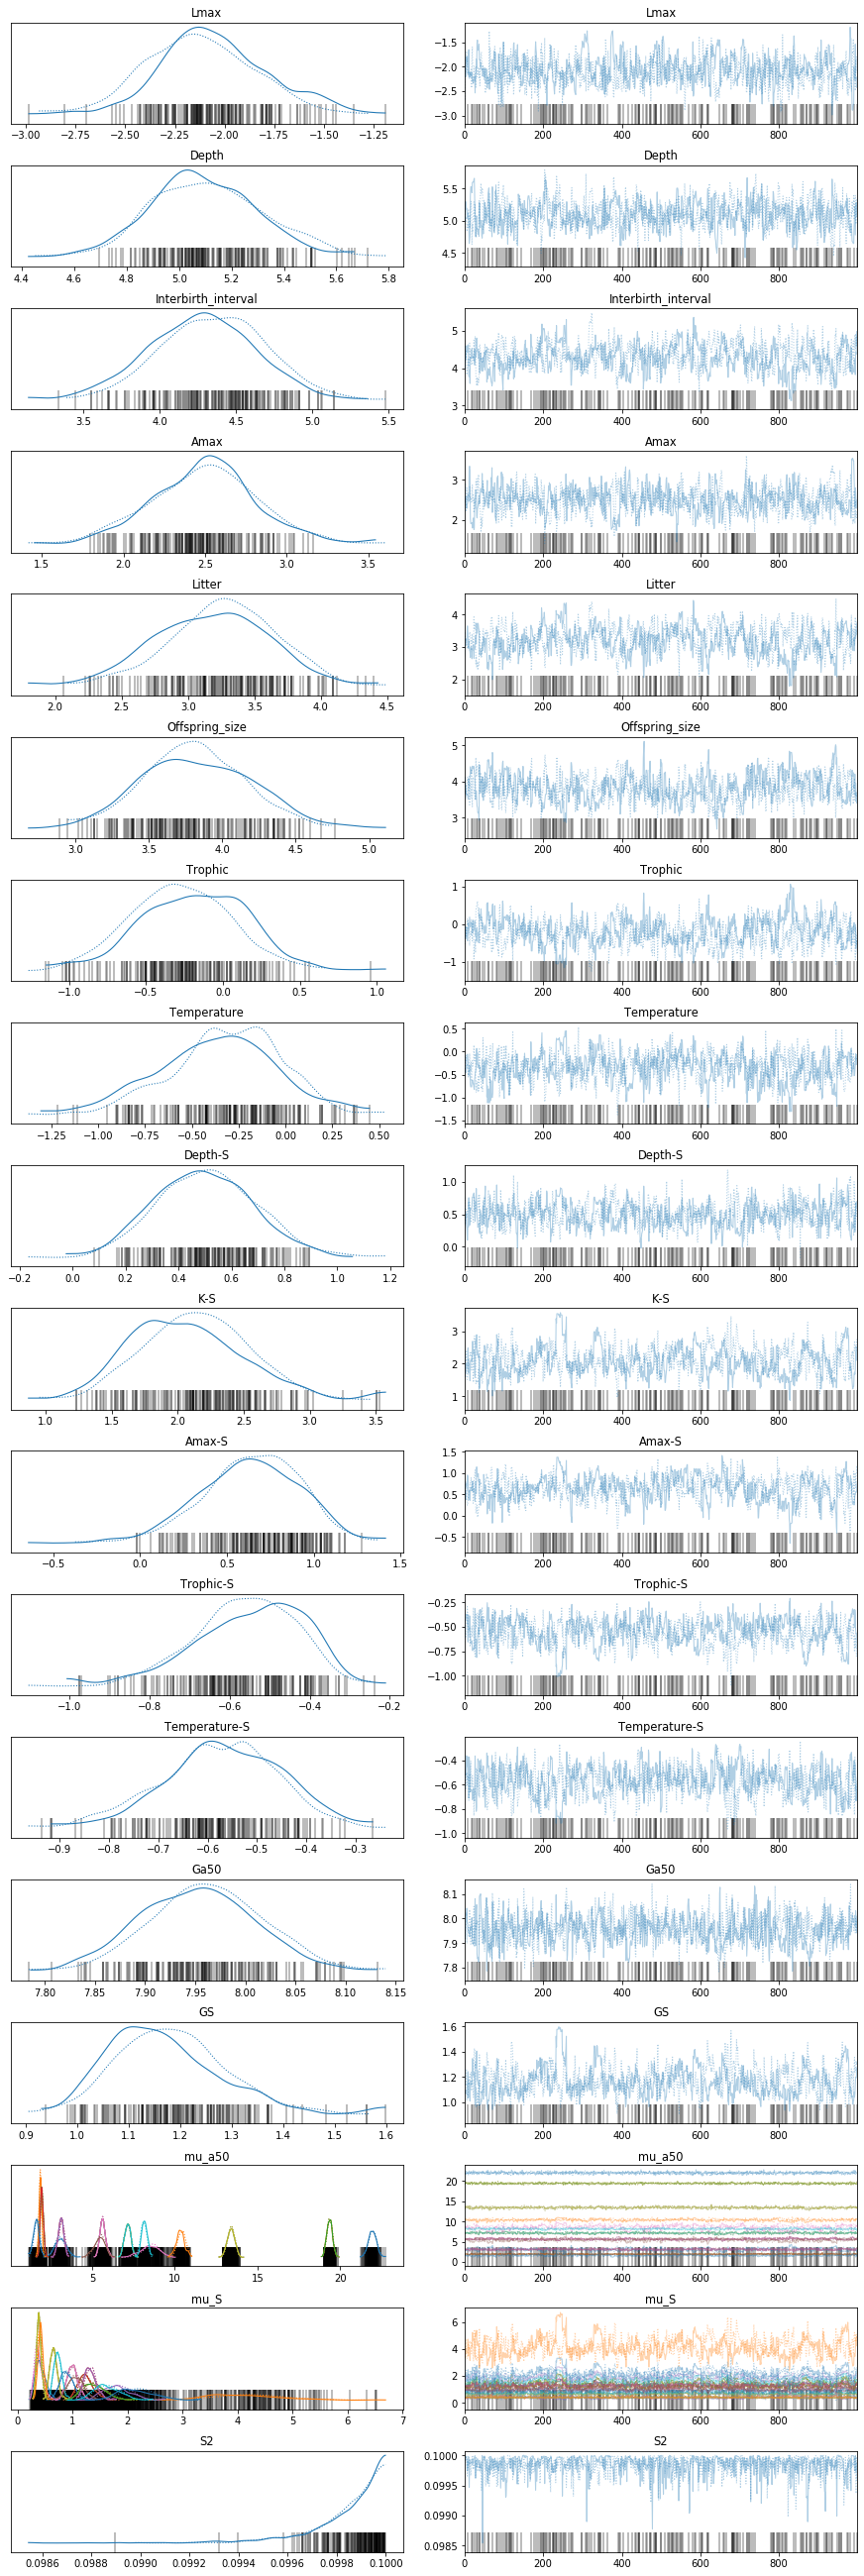

In [42]:
#check model performance
pm.traceplot(trace2);

In [43]:
pm.summary(trace2)
# looking for r-hat valeus of 1 - shows that model is converging

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Lmax,-2.087,0.279,-2.585,-1.534,0.014,0.010,399.0,399.0,406.0,456.0,1.02
Depth,5.101,0.212,4.744,5.529,0.009,0.007,513.0,511.0,519.0,673.0,1.00
Interbirth_interval,4.315,0.353,3.641,4.960,0.025,0.018,201.0,201.0,201.0,272.0,1.01
Amax,2.499,0.313,1.892,3.069,0.015,0.011,414.0,414.0,418.0,494.0,1.00
Litter,3.222,0.419,2.433,3.995,0.030,0.022,189.0,189.0,191.0,396.0,1.01
Offspring_size,3.823,0.364,3.127,4.477,0.024,0.017,229.0,229.0,229.0,487.0,1.01
Trophic,-0.228,0.349,-0.940,0.376,0.030,0.022,131.0,131.0,133.0,272.0,1.02
Temperature,-0.341,0.305,-0.957,0.185,0.020,0.014,231.0,231.0,234.0,288.0,1.01
Depth-S,0.502,0.186,0.160,0.846,0.010,0.007,324.0,315.0,327.0,676.0,1.00
K-S,2.107,0.425,1.376,2.899,0.032,0.023,174.0,166.0,181.0,187.0,1.01


In [44]:
#Save traces for use in prediction
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Predict_Maturity\\Data\\for model\\out\\traces')
pm.save_trace(trace1)

'.pymc_12.trace'

In [45]:
pm.save_trace(trace2)

'.pymc_13.trace'

### Model Results

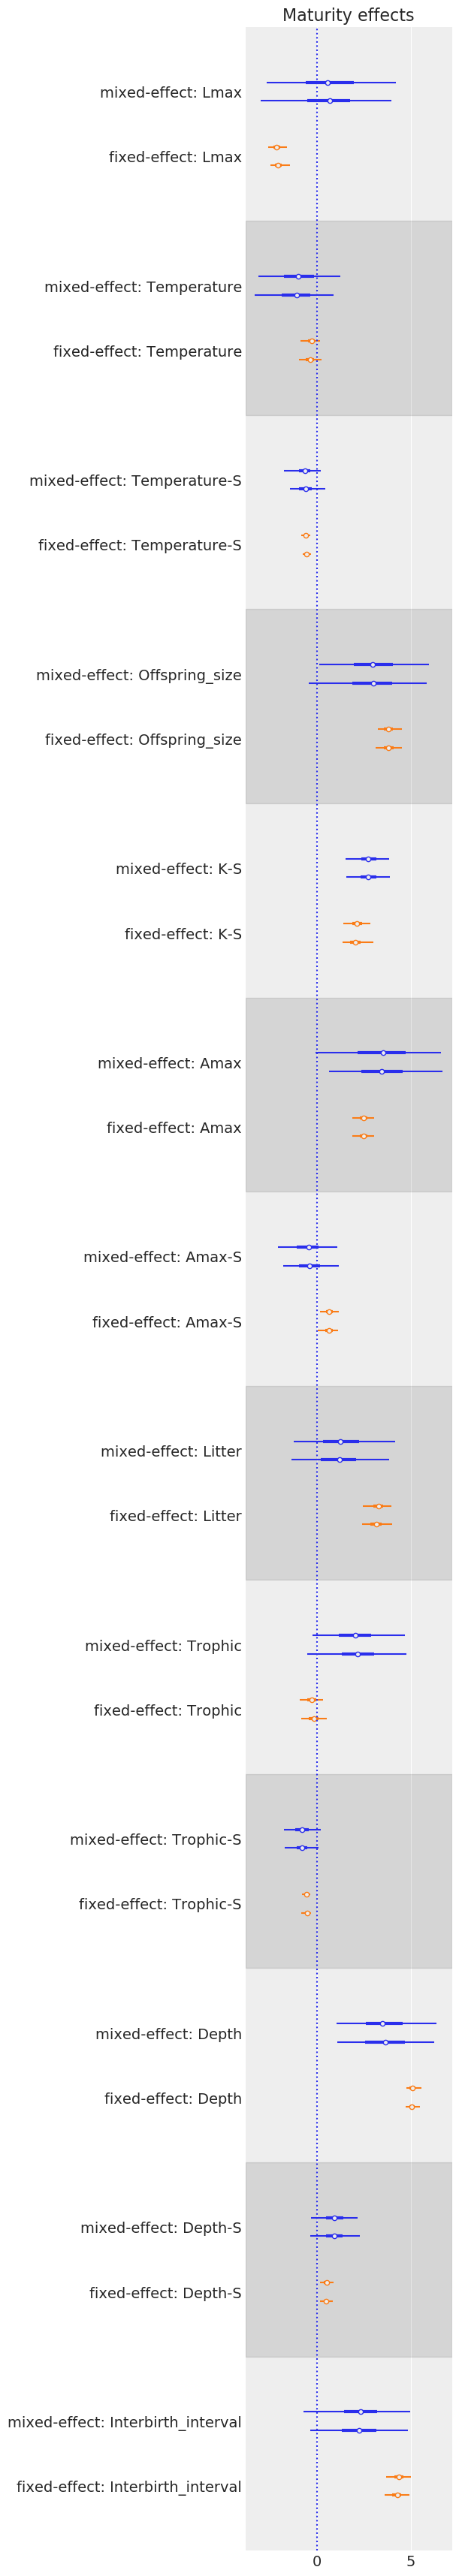

<Figure size 720x480 with 0 Axes>

In [47]:
# Forest plot to see size and direction of cov effects
# Compare mat1 and mat2 (mixed effect vs fixed effect)
az.style.use("arviz-darkgrid")
axes = az.plot_forest(
    [trace1, trace2], model_names=["mixed-effect", "fixed-effect"], var_names=["Lmax", "Temperature", "Temperature-S", "Offspring_size", "K-S", "Amax", "Amax-S", "Litter",  "Trophic", "Trophic-S", "Depth", "Depth-S", "Interbirth_interval"])
axes[0].set_title("Maturity effects")
plt.axvline(0, linestyle=':')
plt.show()

#save figure
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Predict_Maturity\\Data\\for model\\out')
plt.savefig('mat16&17_forest.jpg');

### Model Comparison

In [48]:
#WAIC for model 1 (16)
pm.waic(trace1, scale='deviance')

Computed from 2000 by 485 log-likelihood matrix

              Estimate       SE
deviance_waic -3137.16   122.22
p_waic           89.54        -

There has been a warning during the calculation. Please check the results.

In [49]:
#WAIC for model 2 (17)
pm.waic(trace2, scale='deviance')

Computed from 2000 by 485 log-likelihood matrix

              Estimate       SE
deviance_waic    13.18   163.41
p_waic          180.47        -

There has been a warning during the calculation. Please check the results.

Model 16 WAIC = -3137 
Model 17 (fixed effect) WAIC = 13  


#### Look for 'bad' datapoints

In [50]:
loo1 = pm.loo(trace1, mat1)
loo1

Computed from 2000 by 485 log-likelihood matrix

         Estimate       SE
elpd_loo  1561.06    60.72
p_loo       97.06        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      439   90.5%
 (0.5, 0.7]   (ok)         12    2.5%
   (0.7, 1]   (bad)        25    5.2%
   (1, Inf)   (very bad)    9    1.9%

In [51]:
loo2 = pm.loo(trace2, mat2)
loo2

Computed from 2000 by 485 log-likelihood matrix

         Estimate       SE
elpd_loo    -2.03    80.96
p_loo      175.91        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      439   90.5%
 (0.5, 0.7]   (ok)         30    6.2%
   (0.7, 1]   (bad)         7    1.4%
   (1, Inf)   (very bad)    9    1.9%

In [52]:
badpoints2 = mdata.iloc[loo2.pareto_k.values > 0.7]

In [53]:
badpoints1 = mdata.iloc[loo1.pareto_k.values > 0.7]

### Plot model fits

In [54]:
# Save results to external file - mat1
result1 = pm.backends.tracetab.trace_to_dataframe(trace1)

# Edit column names
# Skip this step - seems unecessary & causes glitches
#colnames = np.array(list(result1.columns), dtype=object)

#colnames[np.array([list(colnames).index(x) for x in grep('a50x',colnames)])] = np.array(['a50_'+str(s) for s in StockYr])
#colnames[np.array([list(colnames).index(x) for x in grep('Sx',colnames)])] = np.array(['S_'+str(s) for s in StockYr])

#result1.columns = list(colnames)

# each model run produces an a50 and S value for each stock-year
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Predict_Maturity\\Data\\for model\\out')
result1.to_csv('mat16_model_results.csv')
result1.head()

,a50___0,a50___1,a50___2,a50___3,a50___4,a50___5,a50___6,a50___7,a50___8,a50___9,...,mu_S__13,mu_S__14,mu_S__15,mu_S__16,mu_S__17,mu_S__18,mu_S__19,mu_S__20,mu_S__21,S2
0,9.992654,8.060392,9.068809,8.118009,6.355548,6.879005,6.378633,4.640186,8.926655,5.155523,...,2.477317,1.499443,2.102351,2.174483,0.489509,0.643556,2.658278,4.786710,1.172508,0.008531
1,8.855558,7.591863,8.875289,7.891968,6.413900,6.919625,6.408917,5.019065,9.275923,5.556951,...,2.373960,1.513904,2.159207,2.355613,0.483330,0.653420,2.629164,5.038372,1.207604,0.009161
2,9.162651,6.961635,7.908473,6.965772,6.852715,7.346341,6.842669,5.049287,9.269631,5.508220,...,2.434478,1.536921,2.046708,2.324960,0.494927,0.642446,2.584308,4.636596,1.220633,0.008810
3,9.935387,6.688138,7.804224,6.884491,6.841463,7.357492,6.848881,6.585164,10.829804,7.135390,...,2.397179,1.588180,2.187970,2.227285,0.483107,0.645736,2.605980,4.639213,1.183930,0.008615
4,9.392817,7.019459,8.475260,7.563602,7.738970,8.238523,7.740762,6.195276,10.466838,6.743675,...,2.577461,1.541537,2.017973,2.264874,0.489519,0.644078,2.533579,4.949383,1.229917,0.008587


In [55]:
# Save results to external file - mat2
result2 = pm.backends.tracetab.trace_to_dataframe(trace2)
result2.to_csv('mat17_model_results.csv')

In [59]:
result1.columns[5:90]

Index(['a50___5', 'a50___6', 'a50___7', 'a50___8', 'a50___9', 'a50___10',
       'a50___11', 'a50___12', 'a50___13', 'a50___14', 'a50___15', 'a50___16',
       'a50___17', 'a50___18', 'a50___19', 'a50___20', 'a50___21', 'Lmax',
       'Depth', 'Interbirth_interval', 'Amax', 'Litter', 'Offspring_size',
       'Trophic', 'Temperature', 'S___0', 'S___1', 'S___2', 'S___3', 'S___4',
       'S___5', 'S___6', 'S___7', 'S___8', 'S___9', 'S___10', 'S___11',
       'S___12', 'S___13', 'S___14', 'S___15', 'S___16', 'S___17', 'S___18',
       'S___19', 'S___20', 'S___21', 'Depth-S', 'K-S', 'Amax-S', 'Trophic-S',
       'Temperature-S', 'Ga50', 'a50_sigma', 'GS', 'S_sigma', 'mu_a50__0',
       'mu_a50__1', 'mu_a50__2', 'mu_a50__3', 'mu_a50__4', 'mu_a50__5',
       'mu_a50__6', 'mu_a50__7', 'mu_a50__8', 'mu_a50__9', 'mu_a50__10',
       'mu_a50__11', 'mu_a50__12', 'mu_a50__13', 'mu_a50__14', 'mu_a50__15',
       'mu_a50__16', 'mu_a50__17', 'mu_a50__18', 'mu_a50__19', 'mu_a50__20',
       'mu_a50__21

In [60]:
# Grab data from mat1 results (model 16)
# Grab a50's
# take median mu_a50 value for each stock-year to visualise effect of covs on a50
μa50s = np.array([np.median(result1[x]) for x in np.array(['mu_a50__'+str(s) for s in list(range(len(StockYr)))])]).T

# can also just look at a50s (no effect of covariates)
a50s = np.array([np.median(result1[x]) for x in np.array(['a50___'+str(s) for s in list(range(len(StockYr)))])]).T

# Grab S's
μSs = np.array([np.median(result1[x]) for x in np.array(['mu_S__'+str(s) for s in list(range(len(StockYr)))])]).T
Ss = np.array([np.median(result1[x]) for x in np.array(['S___'+str(s) for s in list(range(len(StockYr)))])]).T

# xrange
xr = np.linspace(0,max(AGE),max(AGE).astype(int)+1)

In [61]:
result2.columns

Index(['Lmax', 'Depth', 'Interbirth_interval', 'Amax', 'Litter',
       'Offspring_size', 'Trophic', 'Temperature', 'Depth-S', 'K-S', 'Amax-S',
       'Trophic-S', 'Temperature-S', 'Ga50', 'GS', 'mu_a50__0', 'mu_a50__1',
       'mu_a50__2', 'mu_a50__3', 'mu_a50__4', 'mu_a50__5', 'mu_a50__6',
       'mu_a50__7', 'mu_a50__8', 'mu_a50__9', 'mu_a50__10', 'mu_a50__11',
       'mu_a50__12', 'mu_a50__13', 'mu_a50__14', 'mu_a50__15', 'mu_a50__16',
       'mu_a50__17', 'mu_a50__18', 'mu_a50__19', 'mu_a50__20', 'mu_a50__21',
       'mu_S__0', 'mu_S__1', 'mu_S__2', 'mu_S__3', 'mu_S__4', 'mu_S__5',
       'mu_S__6', 'mu_S__7', 'mu_S__8', 'mu_S__9', 'mu_S__10', 'mu_S__11',
       'mu_S__12', 'mu_S__13', 'mu_S__14', 'mu_S__15', 'mu_S__16', 'mu_S__17',
       'mu_S__18', 'mu_S__19', 'mu_S__20', 'mu_S__21', 'S2'],
      dtype='object')

In [62]:
#Grab data from mat2 (model 17 results)
# take median mu_a50 value for each stock-year to visualise effect of covs on a50
μa50s2 = np.array([np.median(result2[x]) for x in np.array(['mu_a50__'+str(s) for s in list(range(len(StockYr)))])]).T


# Grab S's
μSs2 = np.array([np.median(result2[x]) for x in np.array(['mu_S__'+str(s) for s in list(range(len(StockYr)))])]).T

# xrange
# Make a vector of ages from 0 to max age
xr = np.linspace(0,max(AGE),max(AGE).astype(int)+1)

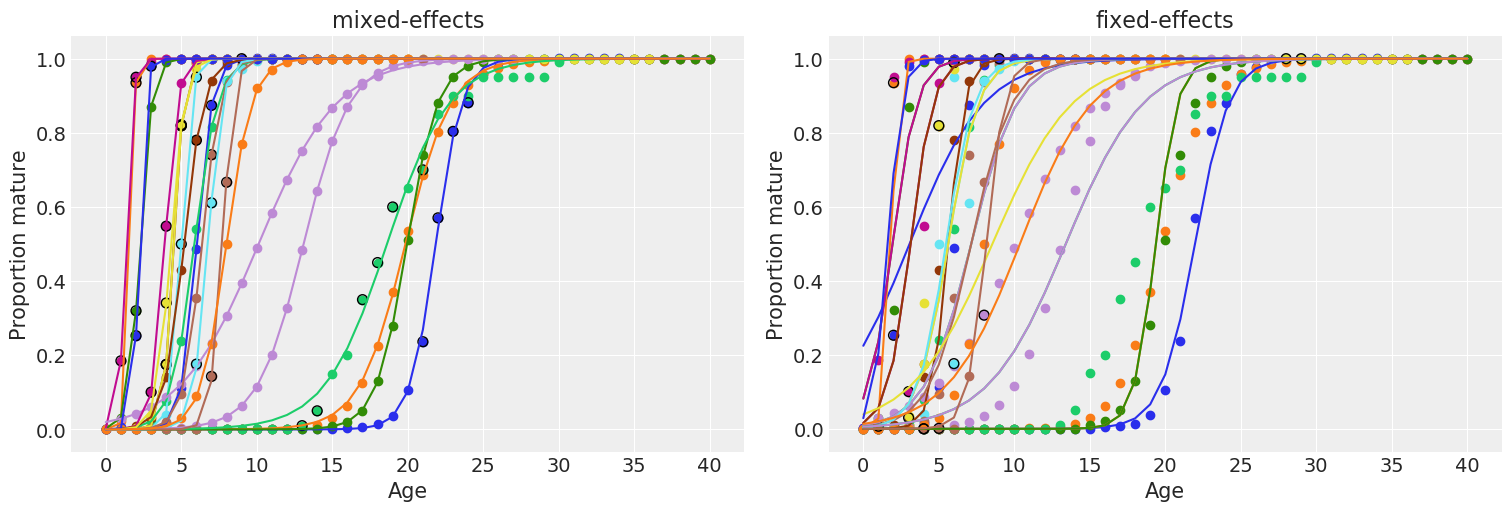

In [63]:
#set up figure
nrows, ncols = 1, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,5))
ax_ = axes.flatten()

#Plot mat16
#scatter plot of mat and age data
[ax_[0].scatter(AGE[mdata.Stock_Year.values==s], MAT[mdata.Stock_Year.values==s]) for s in StockYr]
# add markers for points with bad pareto k scores
ax_[0].scatter(badpoints1.Age, badpoints1.maturity, facecolors='none', edgecolors='k', s=50)
#plot ogives with median S and mu_a50 values
[ax_[0].plot(xr, 1/(1+np.exp(-s*(xr-a)))) for s,a in zip(μSs,μa50s)]
#make plot pretty
ax_[0].set_xlabel('Age',fontsize=15)
ax_[0].set_ylabel('Proportion mature',fontsize=15)
ax_[0].set_title('mixed-effects')

#Plot mat17
#scatter plot of mat and age data
[ax_[1].scatter(AGE[mdata.Stock_Year.values==s], MAT[mdata.Stock_Year.values==s]) for s in StockYr]
# add markers for poitns with high pareto k scores
ax_[1].scatter(badpoints2.Age, badpoints2.maturity, facecolors='none', edgecolors='k', s=50)
#plot ogives with median S and mu_a50 values
[ax_[1].plot(xr, 1/(1+np.exp(-s*(xr-a)))) for s,a in zip(μSs2,μa50s2)]
#make plot pretty
ax_[1].set_xlabel('Age',fontsize=15)
ax_[1].set_ylabel('Proportion mature',fontsize=15)
ax_[1].set_title('fixed-effects')

#save results
plt.savefig('mat16_mat17_modelfit.jpg',dpi=300);

Text(0, 0.5, 'Proportion mature')

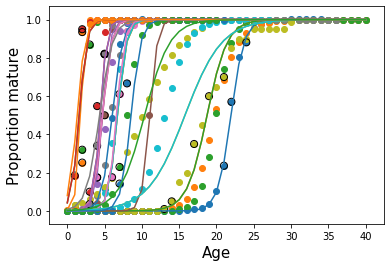

In [112]:
#plot model results against raw data - single plot model 1

#scatter plot of mat and age data
[plt.scatter(AGE[mdata.Stock_Year.values==s], MAT[mdata.Stock_Year.values==s]) for s in StockYr]
#plot ogives with median S and mu_a50 values
[plt.plot(xr, 1/(1+np.exp(-s*(xr-a)))) for s,a in zip(μSs2,μa50s2)]
# plot bad datapoints
plt.scatter(badpoints3.Age, badpoints3.maturity, facecolors='none', edgecolors='k', s=50)
#make plot pretty
plt.xlabel('Age',fontsize=15)
plt.ylabel('Proportion mature',fontsize=15)